In [1]:
import numpy as np
import pandas as pd
from scipy import spatial
# import volpriceinference a vl
import volprice as vl
import matplotlib as mpl
import seaborn as sns
import logging
import tqdm
from multiprocessing import Pool

In [2]:
%matplotlib inline
mpl.style.use('seaborn-talk')
np.set_printoptions(precision=3)

In [3]:
logging.captureWarnings(True)
logging.getLogger().addHandler(logging.FileHandler("logging.tmp.txt"))

## Setup the True Parameters /  Simulation Parameters

In [4]:
true_params = {'equity_price': 0.50, 
               'vol_price': -7,
               'zeta': 1 - (-.02)**2,
               'scale': .1,
               'delta': 1.11,
               'rho': .6,
              }
time_dim = 3000
sim_dim = 1000

## Setup the linking functions.

In [5]:
total_true_params = true_params.copy()
total_true_params.update(
    {'gamma': vl.compute_gamma(rho=true_params['rho'], scale=true_params['scale'], delta=true_params['delta'], 
                       zeta=true_params['zeta'], pi=true_params['vol_price'], theta=true_params['equity_price']),
     'beta':vl.compute_beta(rho=true_params['rho'], scale=true_params['scale'], zeta=true_params['zeta'], 
                    pi=true_params['vol_price'], theta=true_params['equity_price']),
     'psi':vl.compute_psi(rho=true_params['rho'], scale=true_params['scale'], zeta=true_params['zeta'], 
                  theta=true_params['equity_price'])})

## We start by examining the distributions of simulated data

In [6]:
vl.__version__

AttributeError: module 'volprice' has no attribute '__version__'

In [7]:
data = vl.simulate_data(time_dim=time_dim, **true_params)

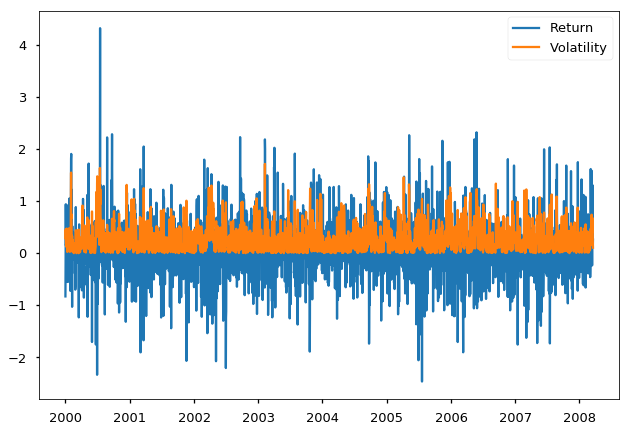

In [8]:
fig1, ax1 = mpl.pyplot.subplots()
ax1.plot(data.rtn, label='Return')
ax1.plot(data.vol, label='Volatility')
ax1.legend()


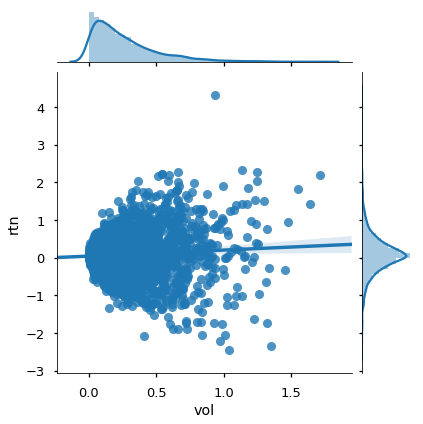

In [9]:
sns.jointplot(x='vol', y='rtn', data=data, kind='reg')

In [10]:
data.describe()

,vol,rtn
count,3000.000000,3000.000000
mean,0.266770,0.082800
std,0.243633,0.532595
min,0.000100,-2.463249
25%,0.088660,-0.181915
50%,0.196692,0.064860
75%,0.372212,0.328474
max,1.712798,4.317992


## The Asymptotic Distributions in the Strongly Identified Case

In [11]:
data_arr = [vl.simulate_data(time_dim=time_dim, **true_params)  for _ in tqdm.tnrange(sim_dim)]

In [12]:
with Pool(8) as pool:
    est_arr = list(tqdm.tqdm_notebook(pool.imap_unordered(vl.estimate_params, data_arr), total=len(data_arr)))

Text(0.5,0,'delta')

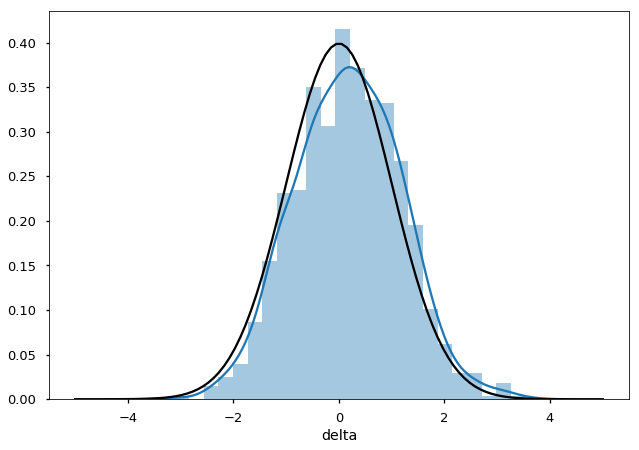

In [13]:
delta_fig, delta_ax = mpl.pyplot.subplots()
sns.distplot([(est['delta'] - true_params['delta']) / np.sqrt(cov.loc['delta','delta']) 
              for est, cov in est_arr], ax=delta_ax)
delta_ax.plot(np.linspace(-5,5,100), stats.norm.pdf(np.linspace(-5,5,100)), color='black')
delta_ax.set_xlabel('delta')

Text(0.5,0,'scale')

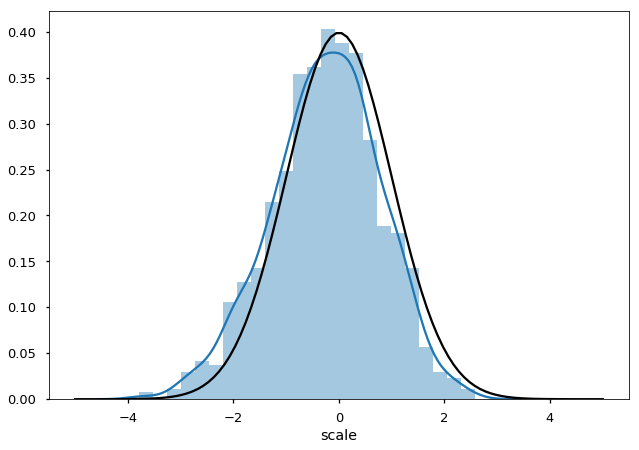

In [14]:
scale_fig, scale_ax = mpl.pyplot.subplots()
sns.distplot([(est['scale'] - true_params['scale']) / np.sqrt(cov.loc['scale', 'scale']) 
              for est, cov in est_arr], ax=scale_ax)
scale_ax.plot(np.linspace(-5,5,100), stats.norm.pdf(np.linspace(-5,5,100)), color='black')
scale_ax.set_xlabel('scale')

Text(0.5,0,'rho')

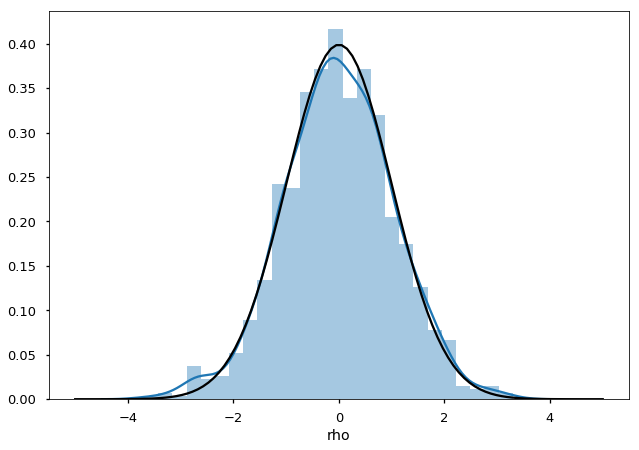

In [15]:
rho_fig, rho_ax = mpl.pyplot.subplots()
sns.distplot([(est['rho'] - true_params['rho']) / np.sqrt(cov.loc['rho', 'rho']) 
              for est, cov in est_arr], ax=rho_ax)
rho_ax.plot(np.linspace(-5,5,100), stats.norm.pdf(np.linspace(-5,5,100)), color='black')
rho_ax.set_xlabel('rho')

(-10, 10)

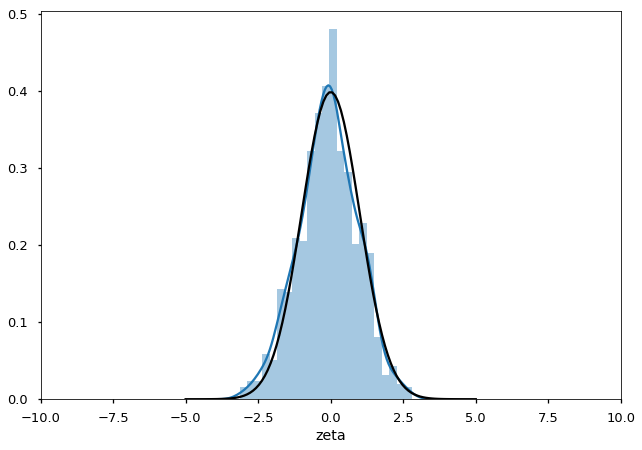

In [16]:
phi_fig, phi_ax = mpl.pyplot.subplots()
sns.distplot([(est['zeta'] - true_params['zeta']) / np.sqrt(cov.loc['zeta', 'zeta'])
              for est, cov in est_arr], ax=phi_ax)
phi_ax.plot(np.linspace(-5,5,100), stats.norm.pdf(np.linspace(-5,5,100)), color='black')
phi_ax.set_xlabel('zeta')
phi_ax.set_xlim([-10,10])

In [17]:
omega, omega_cov = est_arr[0]

In [18]:
qlr_stats = vl.compute_qlr_stats(omega=omega, omega_cov=omega_cov, vol_dim=20, equity_dim=20, equity_max=2,
                                vol_min=-15)

In [19]:
qlr_draws

NameError: name 'qlr_draws' is not defined

In [20]:
vl.qlr_sim([.7, -9], omega=omega, omega_cov=omega_cov, innov_dim=10)

(0.7, -9, 14.888784310716458)

In [ ]:
qlr_draws = vl.compute_qlr_sim(omega=omega, omega_cov=omega_cov, vol_dim=20, equity_dim=20, equity_max=2,
                               vol_min=-15, innov_dim=40)

In [ ]:
accepted_vals = (qlr_stats < qlr_draws).stack().reset_index().rename(columns={0:'value'}).query(
    'value').drop('value', axis='columns')

In [ ]:
fig3, ax3 = mpl.pyplot.subplots()
sns.scatterplot(y=accepted_vals.equity, x=accepted_vals.vol, ax=ax3)
ax3.set_xlim([-15.5, .5])
ax3.set_ylim([-.5,2.5])
hull = spatial.ConvexHull(accepted_vals.values)
ax3.fill(accepted_vals.values[hull.vertices, 0], accepted_vals.values[hull.vertices, 1], 'k-', color='green', 
        alpha=.5)
ax3.scatter([true_params['vol_price']], [true_params['equity_price']], color='black', marker='*', 
         label='True', s=400, zorder=10)
ax3.legend()